# Vacation-planning weather analysis

In [3]:
# Import all dependencies and styles needed for notebook.

# Set Jupyter Notebook to display plots inline.
%matplotlib inline

# Import dependencies.
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# Use fancy matplotlib style for plots.
style.use('fivethirtyeight')

# Use Sqlalchemy library (ORM) to read sqlite database into Python object

In [4]:
# Create db engine for sqlite db.
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# Create inspector object to view tables and columns in sqlite db.
inspector = inspect(engine)

# Use inspector object to print all table names and column schemas.
tables = inspector.get_table_names()
for t in tables:
    # Print table name.
    print(t)
    # Get all schema info for each column.
    column_info = inspector.get_columns(t)
    # For each column, print out schema info.
    for x in column_info:
        print(x)

measurement
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
station
{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}
{'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoin

In [5]:
# Start SQLAlchemy query session for precipitation analysis.
session = Session(engine)

# Create Pandas connection for June vs. December analysis.
conn = engine.connect()

In [6]:
# Create class references to work with tables.

# Read (reflect) sqlite db into SQLAlchemy Base object.
Base = automap_base()
Base.prepare(engine, reflect = True)

# Create reference to each table in Base.
Station = Base.classes.station
Measurement = Base.classes.measurement


# Exploratory Climate Analysis
## Precipitation analysis: 12 months of precipitation data

In [7]:
# View first 5 records from prcp column
result = session.query(Measurement.prcp).limit(5).all()
result

[(0.08), (0.0), (0.0), (0.0), (None)]

In [8]:
# View first 5 records from date column.
result = session.query(Measurement.date).limit(5).all()
result

[('2010-01-01'),
 ('2010-01-02'),
 ('2010-01-03'),
 ('2010-01-04'),
 ('2010-01-06')]

In [9]:
# Compute date one year before last date present in database.

# Query last date in database.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Print last_date
print("Last date in dataset: " + str(last_date))

# ('2017-08-23',) looks like a tuple of strings...

# Index into last_date.
last_date_string = last_date[0]

# Format string as datetime object.
format_str = '%Y-%m-%d'
datetime_obj = dt.datetime.strptime(last_date_string, format_str)

# Subtract 365 years from datetime object.
year_ago = datetime_obj - dt.timedelta(days = 365)
print("One year before last date: " + str(year_ago))

Last date in dataset: ('2017-08-23',)
One year before last date: 2016-08-23 00:00:00


In [10]:
# Get average observed precipitation for each day over last year of data.

# Getting the same data using ORM instead of read_sql.

#Because there are multiple readings per day, group data by day and aggregate to average.
results = session.query(func.min(Measurement.date), func.avg(Measurement.prcp)).\
filter(Measurement.date >= year_ago).group_by(Measurement.date)

# Parse results into 2 lists.
dates = [result[0] for result in results]
p_obs = [result[1] for result in results]

# Convert list of dictionaries into Pandas DataFrame.
precip_df = pd.DataFrame({"Date": dates, "Precip_avg": p_obs})

# Set df index to date column.
precip_df.set_index('Date')

# Sort df by date.
precip_df.sort_index()

precip_df.head()

,Date,Precip_avg
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


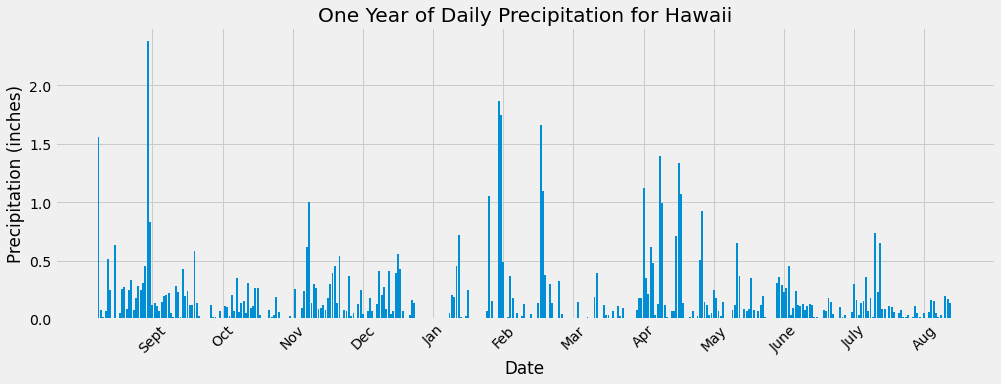

In [11]:
# Plot precipitation by day for last year of data.

# Size figure appropriately.
fig, ax = plt.subplots(figsize=(15, 5))

# Plot prcp vs. date.
plt.bar(precip_df["Date"], precip_df["Precip_avg"])

# Title and axis labels
plt.title('One Year of Daily Precipitation for Hawaii')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')

# Format x-axis tick labels
# Shift first label 7 forward to account for data starting on 8/23 and center month label under data.
ax.set_xticks(np.arange(23, 388, 30))
xticklabels = ["Sept", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug"]
ax.set_xticklabels(xticklabels, rotation = 45)

plt.show()

In [12]:
# Precipitation summary statistics for one year.
precip_df.describe()

,Precip_avg
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


## Temperature analysis: Summary stats and distribution of data from a single station

In [13]:
# Print number of stations, print Station table.
print("There are " + str(session.query(func.count(Station.id)).all()[0][0]) + " stations in the Station dataset:")
print("")
result = session.query(Station)
for row in result:
    print(row.id, row.station, row.name, row.latitude, row.longitude, row.elevation)

There are 9 stations in the Station dataset:

1 USC00519397 WAIKIKI 717.2, HI US 21.2716 -157.8168 3.0
2 USC00513117 KANEOHE 838.1, HI US 21.4234 -157.8015 14.6
3 USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US 21.5213 -157.8374 7.0
4 USC00517948 PEARL CITY, HI US 21.3934 -157.9751 11.9
5 USC00518838 UPPER WAHIAWA 874.3, HI US 21.4992 -158.0111 306.6
6 USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US 21.33556 -157.71139 19.5
7 USC00519281 WAIHEE 837.5, HI US 21.45167 -157.84888999999998 32.9
8 USC00511918 HONOLULU OBSERVATORY 702.2, HI US 21.3152 -157.9992 0.9
9 USC00516128 MANOA LYON ARBO 785.2, HI US 21.3331 -157.8025 152.4


In [14]:
# Find the station with the most measurements by grouping the Measurement table by station, 
# aggregating to count, and sorting descending. This station should provide the most reliable
# information about Hawaii weather.

# Query
result = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# Print result set.
for row in result:
    print(row)
    
print("")

# Extract first cell of first row.
highest_number = result[0][0]

print("Station " + str(highest_number) + " has the highest number of observation days.")

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)

Station USC00519281 has the highest number of observation days.


In [15]:
# For the station with the most observations, print the lowest, highest, and average temperature
# reported for the last year.
lowest = session.query(func.min(Measurement.tobs)).filter(Measurement.station == highest_number).\
filter(Measurement.date >= year_ago)
highest = session.query(func.max(Measurement.tobs)).filter(Measurement.station == highest_number).\
filter(Measurement.date >= year_ago)
average = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == highest_number).\
filter(Measurement.date >= year_ago)

print("Lowest temperature: " + str(lowest[0][0]) + " F")
print("Highest temperature: " + str(highest[0][0]) + " F")
print("Average temperature: " + str(round(average[0][0], 2)) + " F")

Lowest temperature: 59.0 F
Highest temperature: 83.0 F
Average temperature: 73.1 F


In [16]:
# For the station with the most observations, query the last year of temperature data.
results = session.query(Measurement.tobs).filter(Measurement.station == highest_number).\
filter(Measurement.date >= year_ago).all()

# Convert session.query object to Pandas DataFrame.
temp_df = pd.DataFrame(results)

temp_df.head()

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


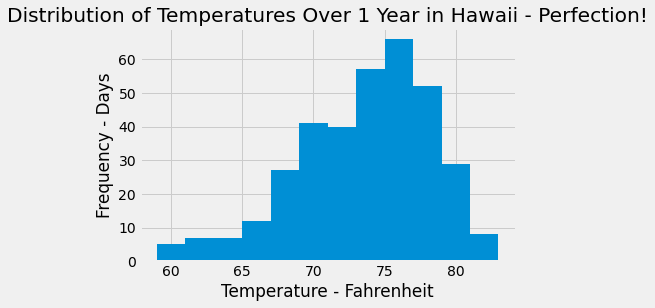

In [17]:
# Plot histogram of last year of temperature data for station with most observations.

plt.hist(temp_df["tobs"], bins = 12)
plt.title("Distribution of Temperatures Over 1 Year in Hawaii - Perfection!")
plt.xlabel("Temperature - Fahrenheit")
plt.ylabel("Frequency - Days")
plt.show()

In [18]:
# This function, called `start_temps` accepts a start date in the format '%Y-%m-%d' 
# and returns the max, min, and average temperatures for all dates in the Measurement
# table since the start date.
def start_temps(start_date):
    """
    Args:
        start_date (string): A date string in the format %Y-%m-%d 
    Returns:
        TMAX, TMIN, and TAVG
    """
    return session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start_date).all()

# function usage example
print(start_temps('2012-02-28'))

[(87.0, 53.0, 73.43127438710152)]


In [19]:
# This function, called `start_end_temps` accepts start and end dates in the format '%Y-%m-%d' 
# and returns the max, min, and average temperatures for all observations in the Measurement
# table that fall within the date range.

def start_end_temps(start_date, end_date):
    """
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d 
    Returns:
        TMAX, TMIN, and TAVG
    """
    return session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(start_end_temps('2012-02-28', '2012-03-05'))

[(74.0, 62.0, 69.57142857142857)]


## Compare average December and June temperatures

In [46]:
# Query months and temperatures from Measurement table and save in Pandas DataFrame.
months_df = pd.read_sql("SELECT strftime('%m', date), tobs FROM Measurement", conn)

# Rename months column.
months_df.rename(columns={"strftime('%m', date)":"month"}, inplace=True)

months_df.head()

,month,tobs
0,01,65.0
1,01,63.0
2,01,74.0
3,01,76.0
4,01,73.0


In [58]:
# Select December temperature observations.
december_df = months_df.loc[months_df["month"] == "12"]

# Caclulate average temperature for all December dates in dataset.
december_avg = december_df.mean()

print("The average temperature in December is: " + str(round(december_avg["tobs"], 0)) + " F")

The average temperature in December is: 71.0 F


In [48]:
# Select June temperature observations.
june_df = months_df.loc[months_df["month"] == "06"]

# Caclulate average temperature for all December dates in dataset.
june_avg = june_df.mean()

print("The average temperature in June is: " + str(round(june_avg["tobs"], 0)) + " F")

The average temperature in June is: 75.0 F


In [60]:
# Perform independent t-test to decide if there is a statistically significant difference in temperature between December and June.
# Using independent t-test because June and December temperature readings differ in many climatological ways and therefore can't
# be considered repeated measurements on the same subjects.

print("The December and June temperature observations are not statistically significantly different.")
import scipy.stats as stats
stats.ttest_ind(december_df["tobs"], june_df["tobs"], equal_var=False)

The December and June temperature observations are not statistically significantly different.


Ttest_indResult(statistic=-31.355036920962423, pvalue=4.193529835915755e-187)